In [ ]:
# Imports and setups
!pip install kagglehub --quiet

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import cv2
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.io import read_image


In [ ]:
import kagglehub

path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
print("Dataset path:", path)

100%|██████████| 105M/105M [00:00<00:00, 169MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [ ]:
train_dir = f"{path}/train"
test_dir  = f"{path}/test"

In [ ]:
# =========================================================
# 3. Custom Dataset Class (using torchvision.io.read_image)
#     This is MUCH faster than Pillow
# =========================================================

class CIFAKEDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = []
        self.labels = []
        self.transform = transform

        real_dir = os.path.join(root_dir, "REAL")
        fake_dir = os.path.join(root_dir, "FAKE")

        for p in os.listdir(real_dir):
            self.paths.append(os.path.join(real_dir, p))
            self.labels.append(0)
        for p in os.listdir(fake_dir):
            self.paths.append(os.path.join(fake_dir, p))
            self.labels.append(1)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = read_image(img_path).float() / 255.0

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).float()

        return img, label


In [ ]:
# =========================================================
# 4. Transformations and DataLoaders
# =========================================================

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ConvertImageDtype(torch.float32)
])

train_dataset = CIFAKEDataset(train_dir, transform)
test_dataset  = CIFAKEDataset(test_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Train samples: 100000
Test samples: 20000


In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# =========================================================
# 5. GPU-Based FFT and Sobel Filters (FAST)
# =========================================================

def extract_fft_gpu(img_batch):
    gray = img_batch.mean(dim=1, keepdim=True)  # [B,1,H,W]

    f = torch.fft.fftn(gray, dim=[2,3])
    fshift = torch.fft.fftshift(f, dim=[2,3])
    mag = torch.log(torch.abs(fshift) + 1e-8)

    return torch.stack([mag.mean(dim=[1,2,3]), mag.std(dim=[1,2,3])], dim=1)

def extract_edges_gpu(img_batch):
    # Convert batch to grayscale
    gray = img_batch.mean(dim=1, keepdim=True)  # [B,1,H,W]

    # Sobel kernels (float32)
    sobel_x = torch.tensor([[[-1., 0., 1.],
                             [-2., 0., 2.],
                             [-1., 0., 1.]]],
                           device=img_batch.device,
                           dtype=torch.float32).unsqueeze(1)

    sobel_y = torch.tensor([[[-1., -2., -1.],
                             [ 0.,  0.,  0.],
                             [ 1.,  2.,  1.]]],
                           device=img_batch.device,
                           dtype=torch.float32).unsqueeze(1)

    # Convolutions
    grad_x = torch.nn.functional.conv2d(gray, sobel_x, padding=1)
    grad_y = torch.nn.functional.conv2d(gray, sobel_y, padding=1)

    grad_mag = torch.sqrt(grad_x**2 + grad_y**2)

    # Edge features
    mean_edge = grad_mag.mean(dim=[1,2,3])
    std_edge  = grad_mag.std(dim=[1,2,3])
    edge_density = (grad_mag > grad_mag.mean()).float().mean(dim=[1,2,3])

    # Laplacian kernel (float32)
    lap_kernel = torch.tensor([[[0.,  1., 0.],
                                [1., -4., 1.],
                                [0.,  1., 0.]]],
                              device=img_batch.device,
                              dtype=torch.float32).unsqueeze(1)

    lap = torch.nn.functional.conv2d(gray, lap_kernel, padding=1)
    lap_var = lap.var(dim=[1,2,3])

    return torch.stack([mean_edge, std_edge, edge_density, lap_var], dim=1)


In [ ]:
# =========================================================
# 6. EfficientNet + FFT + Edge Hybrid Model
# =========================================================

def build_cnn():
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    model.classifier = nn.Identity()
    return model

class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = build_cnn()
        self.fc = nn.Sequential(
            nn.Linear(1280 + 2 + 4, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, fft_feats, edge_feats):
        cnn_out = self.cnn(x)
        combined = torch.cat([cnn_out, fft_feats, edge_feats], dim=1)
        return self.fc(combined)


In [ ]:
# =========================================================
# 7. Train + Evaluate Loops
# =========================================================
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model = HybridModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_epoch(loader):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)

        fft_feats = extract_fft_gpu(imgs)
        edge_feats = extract_edges_gpu(imgs)

        preds = model(imgs, fft_feats, edge_feats)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device).unsqueeze(1)

            fft_feats = extract_fft_gpu(imgs)
            edge_feats = extract_edges_gpu(imgs)

            preds = model(imgs, fft_feats, edge_feats)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, np.round(y_pred))
    auc = roc_auc_score(y_true, y_pred)

    return acc, auc

def evaluate_val(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.float().to(device).unsqueeze(1)

            fft = extract_fft_gpu(imgs)
            edges = extract_edges_gpu(imgs)

            outputs = model(imgs, fft, edges)

            # store
            y_true.extend(labels.cpu().numpy().flatten().tolist())
            y_pred.extend(outputs.cpu().numpy().flatten().tolist())

            # batch loss
            loss = nn.BCELoss()(outputs, labels)
            losses.append(loss.item())

    # convert lists to tensors properly (NO UNSQUEEZE)
    y_true_t = torch.tensor(y_true).float().unsqueeze(1)  # [N,1]
    y_pred_t = torch.tensor(y_pred).float().unsqueeze(1)  # [N,1]

    val_loss = nn.BCELoss()(y_pred_t, y_true_t).item()

    val_acc = accuracy_score((y_pred_t > 0.5).int(), y_true_t.int())
    val_auc = roc_auc_score(y_true, y_pred)

    return val_loss, val_acc, val_auc


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 139MB/s]


In [ ]:
# =========================================================
# Comprehensive Training for All Model Variants
# =========================================================
import json
import copy

EPOCHS = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

# =========================================================
# Model Variants (Moved from cell 38p39KAczkml)
# =========================================================
class CNNOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = build_cnn()
        self.fc = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, fft_feats, edge_feats):
        cnn_out = self.cnn(x)
        return self.fc(cnn_out)

class FFTOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x, fft_feats, edge_feats):
        return self.fc(fft_feats)

class EdgesOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x, fft_feats, edge_feats):
        return self.fc(edge_feats)

class FFTPlusEdgesModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x, fft_feats, edge_feats):
        feats = torch.cat([fft_feats, edge_feats], dim=1)
        return self.fc(feats)

# Define all model configurations
model_configs = {
    "CNN_Only": {
        "model_class": CNNOnlyModel,
        "features": "CNN only",
        "use_fft": False,
        "use_edges": False
    },
    "FFT_Only": {
        "model_class": FFTOnlyModel,
        "features": "FFT only",
        "use_fft": True,
        "use_edges": False
    },
    "Edges_Only": {
        "model_class": EdgesOnlyModel,
        "features": "Edges only",
        "use_fft": False,
        "use_edges": True
    },
    "FFT_Plus_Edges": {
        "model_class": FFTPlusEdgesModel,
        "features": "FFT + Edges",
        "use_fft": True,
        "use_edges": True
    },
    "Hybrid_All": {
        "model_class": HybridModel,
        "features": "CNN + FFT + Edges",
        "use_fft": True,
        "use_edges": True
    }
}

# Training function for a single model
def train_model_variant(model_name, config, train_loader, val_loader, epochs=EPOCHS):
    print(f"\n{'='*60}")
    print(f"Training: {model_name} ({config['features']})")
    print(f"{'='*60}")

    model = config["model_class"]().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "val_auc": []
    }

    best_val_acc = 0.0
    best_model_state = None
    best_epoch = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        train_correct = 0
        train_total = 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)

            # Extract features (models will ignore what they don't need)
            fft_feats = extract_fft_gpu(imgs)
            edge_feats = extract_edges_gpu(imgs)

            preds = model(imgs, fft_feats, edge_feats)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_correct += ((preds > 0.5).int() == labels.int()).sum().item()
            train_total += labels.size(0)

        avg_train_loss = np.mean(train_losses)
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0
        y_true = []
        y_pred = []

        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                imgs = imgs.to(device)
                labels = labels.float().to(device).unsqueeze(1)

                # Extract features (models will ignore what they don't need)
                fft_feats = extract_fft_gpu(imgs)
                edge_feats = extract_edges_gpu(imgs)

                outputs = model(imgs, fft_feats, edge_feats)

                loss = criterion(outputs, labels)
                val_losses.append(loss.item())

                val_correct += ((outputs > 0.5).int() == labels.int()).sum().item()
                val_total += labels.size(0)

                y_true.extend(labels.cpu().numpy().flatten().tolist())
                y_pred.extend(outputs.cpu().numpy().flatten().tolist())

        avg_val_loss = np.mean(val_losses)
        val_acc = val_correct / val_total
        val_auc = roc_auc_score(y_true, y_pred)

        # Update history
        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            print(f"  ✓ New best validation accuracy: {best_val_acc:.4f}")

    return model, history, best_model_state, best_val_acc, best_epoch

# Train all model variants
results_dict = {}
all_models = {}

for model_name, config in model_configs.items():
    model, history, best_state, best_val_acc, best_epoch = train_model_variant(
        model_name, config, train_loader, val_loader, epochs=EPOCHS
    )

    # Save best model
    save_path = f"best_{model_name.lower()}_model.pth"
    torch.save(best_state, save_path)
    print(f"\nBest model saved to: {save_path}")

    # Get best training metrics (at the epoch with best validation accuracy)
    best_train_loss = history["train_loss"][best_epoch - 1]
    best_train_acc = history["train_acc"][best_epoch - 1]
    best_val_loss = history["val_loss"][best_epoch - 1]

    # Convert state dict to CPU for summary
    cpu_state = {k: v.cpu() if hasattr(v, 'cpu') else v for k, v in best_state.items()}

    # Store results
    results_dict[model_name] = {
        "features": config["features"],
        "use_fft": config["use_fft"],
        "use_edges": config["use_edges"],
        "best_epoch": best_epoch,
        "best_train_loss": float(best_train_loss),
        "best_train_acc": float(best_train_acc),
        "best_val_loss": float(best_val_loss),
        "best_val_acc": float(best_val_acc),
        "best_val_auc": float(history["val_auc"][best_epoch - 1]),
        "model_path": save_path,
        "model_weights_summary": {
            k: {
                "shape": list(v.shape) if hasattr(v, 'shape') else [],
                "mean": float(v.mean().item()) if hasattr(v, 'mean') and len(v.shape) > 0 else float(v.item()) if hasattr(v, 'item') else 0.0,
                "std": float(v.std().item()) if hasattr(v, 'std') and len(v.shape) > 0 else 0.0,
                "min": float(v.min().item()) if hasattr(v, 'min') and len(v.shape) > 0 else float(v.item()) if hasattr(v, 'item') else 0.0,
                "max": float(v.max().item()) if hasattr(v, 'max') and len(v.shape) > 0 else float(v.item()) if hasattr(v, 'item') else 0.0
            }
            for k, v in cpu_state.items()
        }
    }

    all_models[model_name] = {
        "model": model,
        "history": history
    }

# Save results dictionary
with open("model_comparison_results.json", "w") as f:
    json.dump(results_dict, f, indent=2)

print(f"\n{'='*60}")
print("TRAINING COMPLETE - SUMMARY")
print(f"{'='*60}")
print(f"\n{'Model':<20} {'Features':<25} {'Train Acc':<12} {'Val Acc':<12} {'Val Loss':<12}")
print("-" * 80)

for model_name, results in results_dict.items():
    print(f"{model_name:<20} {results['features']:<25} "
          f"{results['best_train_acc']:<12.4f} {results['best_val_acc']:<12.4f} "
          f"{results['best_val_loss']:<12.4f}")

print(f"\nResults saved to: model_comparison_results.json")
print(f"Best models saved with prefix: best_*_model.pth")


Training: CNN_Only (CNN only)


Epoch 1/3 - Validation: 100%|██████████| 625/625 [00:26<00:00, 23.82it/s]


Epoch 1/3:
  Train Loss: 0.1332 | Train Acc: 0.9486
  Val Loss: 0.0641 | Val Acc: 0.9762 | Val AUC: 0.9977
  ✓ New best validation accuracy: 0.9762


Epoch 2/3 - Validation: 100%|██████████| 625/625 [00:26<00:00, 23.89it/s]


Epoch 2/3:
  Train Loss: 0.0598 | Train Acc: 0.9776
  Val Loss: 0.0753 | Val Acc: 0.9731 | Val AUC: 0.9968


Epoch 3/3 - Validation: 100%|██████████| 625/625 [00:26<00:00, 23.83it/s]
/tmp/ipython-input-47911869.py:242: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "std": float(v.std().item()) if hasattr(v, 'std') and len(v.shape) > 0 else 0.0,


Epoch 3/3:
  Train Loss: 0.0392 | Train Acc: 0.9857
  Val Loss: 0.0520 | Val Acc: 0.9812 | Val AUC: 0.9985
  ✓ New best validation accuracy: 0.9812

Best model saved to: best_cnn_only_model.pth

Training: FFT_Only (FFT only)


Epoch 1/3 - Validation: 100%|██████████| 625/625 [00:17<00:00, 36.59it/s]


Epoch 1/3:
  Train Loss: 0.6925 | Train Acc: 0.5219
  Val Loss: 0.6885 | Val Acc: 0.5531 | Val AUC: 0.6258
  ✓ New best validation accuracy: 0.5531


Epoch 2/3 - Validation: 100%|██████████| 625/625 [00:17<00:00, 36.56it/s]


Epoch 2/3:
  Train Loss: 0.6890 | Train Acc: 0.5353
  Val Loss: 0.6867 | Val Acc: 0.5410 | Val AUC: 0.6240


Epoch 3/3 - Validation: 100%|██████████| 625/625 [00:16<00:00, 37.83it/s]
/tmp/ipython-input-47911869.py:242: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "std": float(v.std().item()) if hasattr(v, 'std') and len(v.shape) > 0 else 0.0,


Epoch 3/3:
  Train Loss: 0.6872 | Train Acc: 0.5479
  Val Loss: 0.6855 | Val Acc: 0.5644 | Val AUC: 0.6177
  ✓ New best validation accuracy: 0.5644

Best model saved to: best_fft_only_model.pth

Training: Edges_Only (Edges only)


Epoch 1/3 - Validation: 100%|██████████| 625/625 [00:17<00:00, 36.67it/s]


Epoch 1/3:
  Train Loss: 0.6932 | Train Acc: 0.5133
  Val Loss: 0.6909 | Val Acc: 0.5256 | Val AUC: 0.5955
  ✓ New best validation accuracy: 0.5256


Epoch 2/3 - Validation: 100%|██████████| 625/625 [00:17<00:00, 36.62it/s]


Epoch 2/3:
  Train Loss: 0.6897 | Train Acc: 0.5495
  Val Loss: 0.6878 | Val Acc: 0.5843 | Val AUC: 0.6216
  ✓ New best validation accuracy: 0.5843


Epoch 3/3 - Validation: 100%|██████████| 625/625 [00:17<00:00, 36.67it/s]
/tmp/ipython-input-47911869.py:242: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "std": float(v.std().item()) if hasattr(v, 'std') and len(v.shape) > 0 else 0.0,


Epoch 3/3:
  Train Loss: 0.6863 | Train Acc: 0.5677
  Val Loss: 0.6837 | Val Acc: 0.5906 | Val AUC: 0.6273
  ✓ New best validation accuracy: 0.5906

Best model saved to: best_edges_only_model.pth

Training: FFT_Plus_Edges (FFT + Edges)


Epoch 1/3 - Validation: 100%|██████████| 625/625 [00:16<00:00, 36.92it/s]


Epoch 1/3:
  Train Loss: 0.6861 | Train Acc: 0.5645
  Val Loss: 0.6779 | Val Acc: 0.6419 | Val AUC: 0.7014
  ✓ New best validation accuracy: 0.6419


Epoch 2/3 - Validation: 100%|██████████| 625/625 [00:17<00:00, 36.35it/s]


Epoch 2/3:
  Train Loss: 0.6741 | Train Acc: 0.6140
  Val Loss: 0.6671 | Val Acc: 0.6516 | Val AUC: 0.7037
  ✓ New best validation accuracy: 0.6516


Epoch 3/3 - Validation: 100%|██████████| 625/625 [00:16<00:00, 36.78it/s]
/tmp/ipython-input-47911869.py:242: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "std": float(v.std().item()) if hasattr(v, 'std') and len(v.shape) > 0 else 0.0,


Epoch 3/3:
  Train Loss: 0.6643 | Train Acc: 0.6273
  Val Loss: 0.6573 | Val Acc: 0.6560 | Val AUC: 0.7065
  ✓ New best validation accuracy: 0.6560

Best model saved to: best_fft_plus_edges_model.pth

Training: Hybrid_All (CNN + FFT + Edges)


Epoch 1/3 - Validation: 100%|██████████| 625/625 [00:26<00:00, 23.85it/s]


Epoch 1/3:
  Train Loss: 0.1339 | Train Acc: 0.9487
  Val Loss: 0.0649 | Val Acc: 0.9768 | Val AUC: 0.9974
  ✓ New best validation accuracy: 0.9768


Epoch 2/3 - Validation: 100%|██████████| 625/625 [00:26<00:00, 23.88it/s]


Epoch 2/3:
  Train Loss: 0.0631 | Train Acc: 0.9771
  Val Loss: 0.0541 | Val Acc: 0.9799 | Val AUC: 0.9982
  ✓ New best validation accuracy: 0.9799


Epoch 3/3 - Validation: 100%|██████████| 625/625 [00:26<00:00, 23.85it/s]


Epoch 3/3:
  Train Loss: 0.0408 | Train Acc: 0.9854
  Val Loss: 0.0529 | Val Acc: 0.9808 | Val AUC: 0.9983
  ✓ New best validation accuracy: 0.9808

Best model saved to: best_hybrid_all_model.pth

TRAINING COMPLETE - SUMMARY

Model                Features                  Train Acc    Val Acc      Val Loss    
--------------------------------------------------------------------------------
CNN_Only             CNN only                  0.9857       0.9812       0.0520      
FFT_Only             FFT only                  0.5479       0.5644       0.6855      
Edges_Only           Edges only                0.5677       0.5906       0.6837      
FFT_Plus_Edges       FFT + Edges               0.6273       0.6560       0.6573      
Hybrid_All           CNN + FFT + Edges         0.9854       0.9808       0.0529      

Results saved to: model_comparison_results.json
Best models saved with prefix: best_*_model.pth


/tmp/ipython-input-47911869.py:242: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "std": float(v.std().item()) if hasattr(v, 'std') and len(v.shape) > 0 else 0.0,


In [ ]:
# =========================================================
# Load and Display Results
# =========================================================
import json

# Load the results dictionary
with open("model_comparison_results.json", "r") as f:
    loaded_results = json.load(f)

print("="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(f"\n{'Model Name':<20} {'Features':<30} {'Train Acc':<12} {'Val Acc':<12} {'Val Loss':<12} {'Val AUC':<12}")
print("-"*100)

for model_name, results in loaded_results.items():
    print(f"{model_name:<20} {results['features']:<30} "
          f"{results['best_train_acc']:<12.4f} {results['best_val_acc']:<12.4f} "
          f"{results['best_val_loss']:<12.4f} {results['best_val_auc']:<12.4f}")

# Find best model
best_model_name = max(loaded_results.keys(), key=lambda x: loaded_results[x]['best_val_acc'])
best_model_info = loaded_results[best_model_name]

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"Features: {best_model_info['features']}")
print(f"Best Epoch: {best_model_info['best_epoch']}")
print(f"Training Accuracy: {best_model_info['best_train_acc']:.4f}")
print(f"Validation Accuracy: {best_model_info['best_val_acc']:.4f}")
print(f"Validation Loss: {best_model_info['best_val_loss']:.4f}")
print(f"Validation AUC: {best_model_info['best_val_auc']:.4f}")
print(f"Model Path: {best_model_info['model_path']}")

# Display full results dictionary structure
print(f"\n{'='*80}")
print("FULL RESULTS DICTIONARY STRUCTURE")
print(f"{'='*80}")
print(json.dumps(loaded_results, indent=2))


MODEL COMPARISON RESULTS

Model Name           Features                       Train Acc    Val Acc      Val Loss     Val AUC     
----------------------------------------------------------------------------------------------------
CNN_Only             CNN only                       0.9857       0.9812       0.0520       0.9985      
FFT_Only             FFT only                       0.5479       0.5644       0.6855       0.6177      
Edges_Only           Edges only                     0.5677       0.5906       0.6837       0.6273      
FFT_Plus_Edges       FFT + Edges                    0.6273       0.6560       0.6573       0.7065      
Hybrid_All           CNN + FFT + Edges              0.9854       0.9808       0.0529       0.9983      

BEST MODEL: CNN_Only
Features: CNN only
Best Epoch: 3
Training Accuracy: 0.9857
Validation Accuracy: 0.9812
Validation Loss: 0.0520
Validation AUC: 0.9985
Model Path: best_cnn_only_model.pth

FULL RESULTS DICTIONARY STRUCTURE
{
  "CNN_Only": {
    

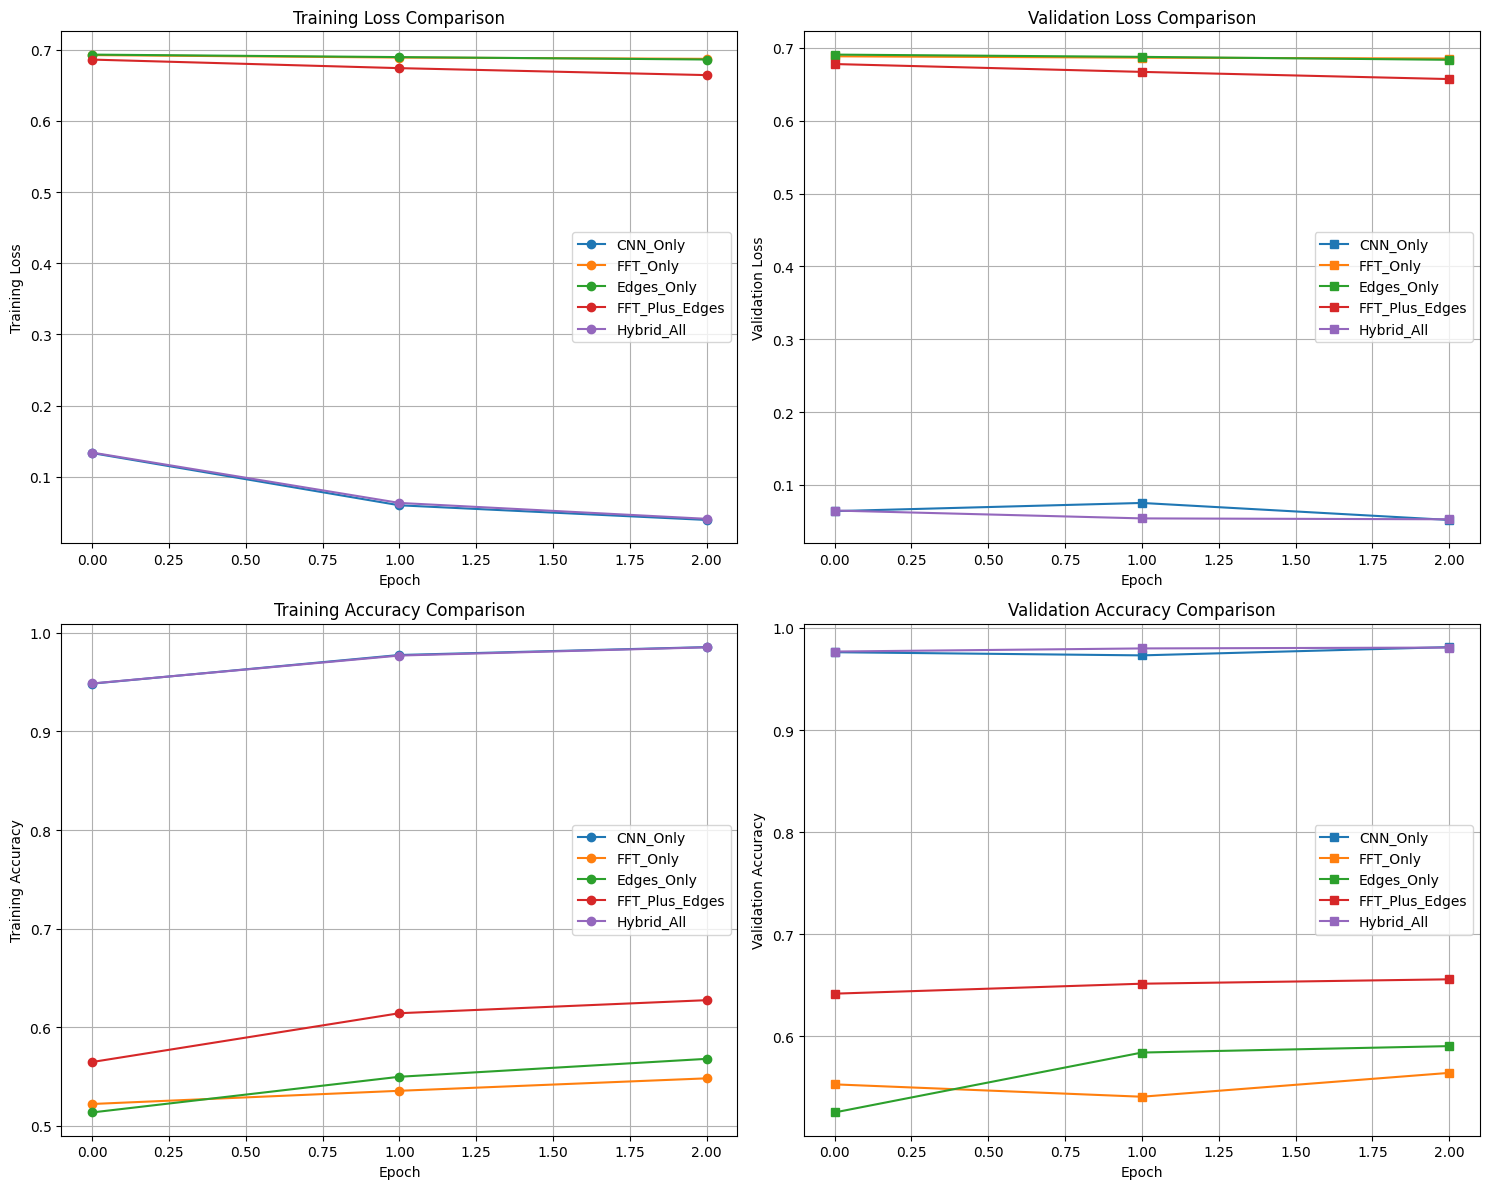

Comparison plots saved to: model_comparison_curves.png


In [ ]:
# =========================================================
# Visualize Training Curves for All Models
# =========================================================
import matplotlib.pyplot as plt

# Load results if not already in memory
if 'all_models' not in locals() or len(all_models) == 0:
    print("Note: Run the training cell first to generate plots")
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Training Loss
    ax1 = axes[0, 0]
    for model_name, model_data in all_models.items():
        history = model_data["history"]
        ax1.plot(history["train_loss"], label=f"{model_name}", marker='o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss Comparison')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Validation Loss
    ax2 = axes[0, 1]
    for model_name, model_data in all_models.items():
        history = model_data["history"]
        ax2.plot(history["val_loss"], label=f"{model_name}", marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss Comparison')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Training Accuracy
    ax3 = axes[1, 0]
    for model_name, model_data in all_models.items():
        history = model_data["history"]
        ax3.plot(history["train_acc"], label=f"{model_name}", marker='o')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Training Accuracy')
    ax3.set_title('Training Accuracy Comparison')
    ax3.legend()
    ax3.grid(True)

    # Plot 4: Validation Accuracy
    ax4 = axes[1, 1]
    for model_name, model_data in all_models.items():
        history = model_data["history"]
        ax4.plot(history["val_acc"], label=f"{model_name}", marker='s')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Validation Accuracy')
    ax4.set_title('Validation Accuracy Comparison')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.savefig('model_comparison_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Comparison plots saved to: model_comparison_curves.png")


In [ ]:
loaded_model = HybridModel().to(device)
loaded_model.load_state_dict(torch.load(save_path, map_location=device))
loaded_model.eval()

print("Model loaded successfully.")

Model loaded successfully.


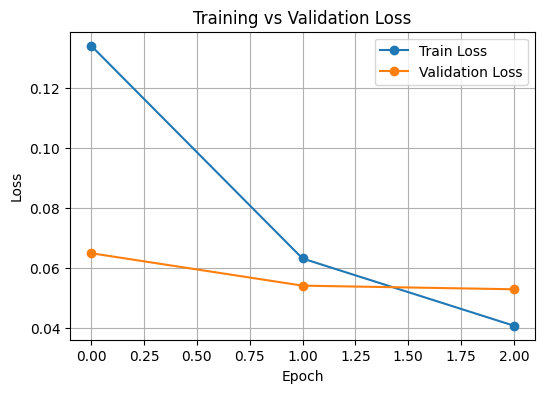

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="Train Loss", marker="o")
plt.plot(history["val_loss"], label="Validation Loss", marker="o")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.plot(epochs, history["train_loss"], marker="o")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,3,2)
plt.plot(epochs, history["test_acc"], marker="o")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1,3,3)
plt.plot(epochs, history["test_auc"], marker="o")
plt.title("Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")

plt.tight_layout()
plt.show()


In [ ]:
from torch.nn import functional as F

class GradCAM:
    def __init__(self, model, target_layer_name="features.7"):
        self.model = model
        self.model.eval()

        self.gradients = None
        self.activations = None

        # get reference to the target layer
        self.target_layer = dict([*self.model.cnn.named_modules()])[target_layer_name]

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        def forward_hook(module, inp, out):
            self.activations = out

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, img_tensor, fft_feats, edge_feats, index=None):
        self.model.zero_grad()

        output = self.model(img_tensor, fft_feats, edge_feats)
        if index is None:
            index = output.argmax(dim=1).item()

        target = output[0, index]
        target.backward()

        gradients = self.gradients[0]      # [C,H,W]
        activations = self.activations[0]  # [C,H,W]

        weights = gradients.mean(dim=(1,2))
        cam = torch.zeros(activations.shape[1:], device=img_tensor.device)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = cam.detach().cpu().numpy()
        return cam


In [ ]:
class CNNOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = build_cnn()
        self.fc = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, fft_feats, edge_feats):
        cnn_out = self.cnn(x)
        return self.fc(cnn_out)

class FFTOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x, fft_feats, edge_feats):
        return self.fc(fft_feats)

class EdgesOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x, fft_feats, edge_feats):
        return self.fc(edge_feats)

class FFTPlusEdgesModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x, fft_feats, edge_feats):
        feats = torch.cat([fft_feats, edge_feats], dim=1)
        return self.fc(feats)
